In [1]:
import tensorflow as tf
import tensorflow.keras as tk
import numpy as np
import matplotlib.pyplot as plt

2022-09-29 14:10:52.710307: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 14:10:52.714372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 14:10:52.714388: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
from tqdm import trange
from collections import defaultdict
import pickle

### Parameters

In [3]:
past_stepsize = 1
past_windowsize = 20
pred_stepsize = 10
pred_windowsize = 10

### Functions

In [4]:
def pos_encoder(pos, freq=400, d=4):
    pos_enc = np.zeros([pos.shape[0], d], dtype=np.float32)
    for i in range(d):
        if i % 2 == 0:
            pos_enc[:, i] = np.sin(pos / (freq ** (i / d)))
        else:
            pos_enc[:, i] = np.cos(pos / (freq ** (i / d)))
    return pos_enc

def data_loader(file_prefix, phase):
    # past data column: ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
    data = np.load(file_prefix + 'dataset_past_' + str(phase) + '.npy', mmap_mode='r')
    data = data.astype('float32')
    past = data[:,  -past_stepsize*(past_windowsize-1)-1::past_stepsize]
    past = past.astype('float32')
    map_data = np.load(file_prefix + 'dataset_map_' + str(phase) + '.npy')
    map_data = map_data.astype('float32')
    pred = np.load(file_prefix + 'dataset_pred_' + str(phase) + '.npy')
    if pred_stepsize == 10:
        pred = pred[:, 1::2]
    pred = pred.astype('float32')
    dist = np.load(file_prefix + 'dataset_dist_' + str(phase) + '.npy')

    return past, map_data, pred, dist

    return past, map_data, pred, dist

### Load Trained Model

In [5]:
results_path = './results/att_fwpos_20220602-150355/'
model_path = results_path+'model_pb/'
model = tk.models.load_model(model_path)

2022-09-29 14:10:54.626228: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 14:10:54.626287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-09-29 14:10:54.626337: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-09-29 14:10:54.626368: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2022-09-29 14:10:54.626397: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

### Load data for Test

In [6]:
file_prefix = '../data/hatci_clinic/1st_TD_matched/dataset_1/'
data_past, data_map, data_pred, data_dist = data_loader(file_prefix, 'test')

# data scale
past_max = np.load(results_path+'evaluations/past_max.npy')
scaled_data_past = data_past/past_max
map_max = np.load(results_path+'evaluations/map_max.npy')
scaled_data_map = data_map/map_max
pred_max = np.load(results_path+'evaluations/pred_max.npy')
scaled_data_pred = data_pred/pred_max

### Visualize dataset

In [7]:
legends = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
legends2 = ['radius', 'slope', 'property', 'type']

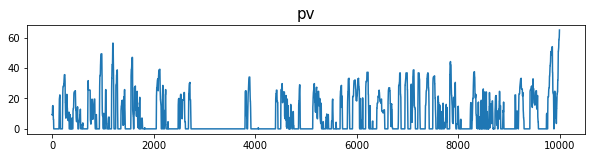

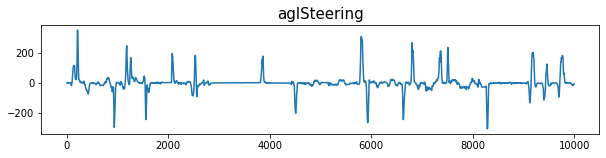

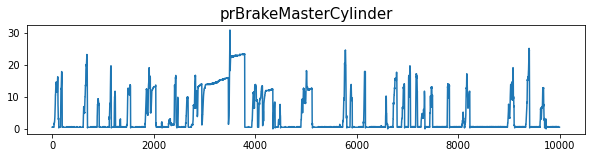

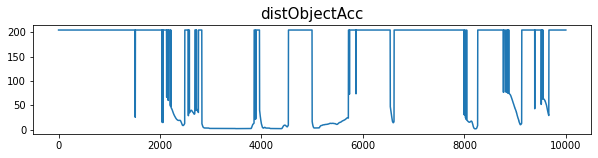

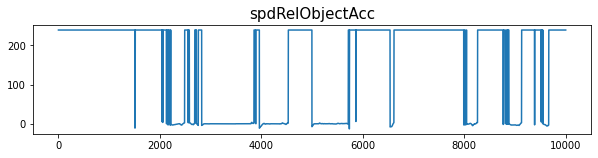

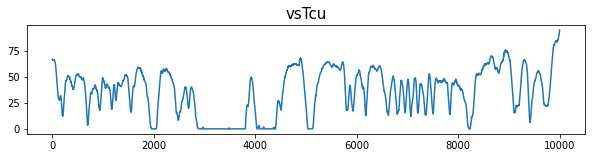

In [8]:
for i in range(6):
    plt.figure(figsize=(10,2))
    plt.title(legends[i], fontsize=15)
    plt.plot(data_past[:10000,0,i])
    plt.show()
    

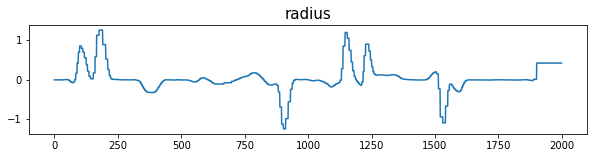

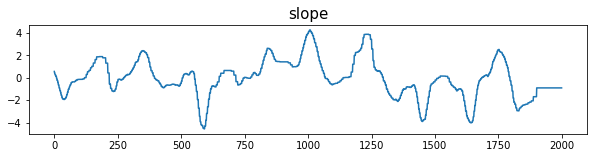

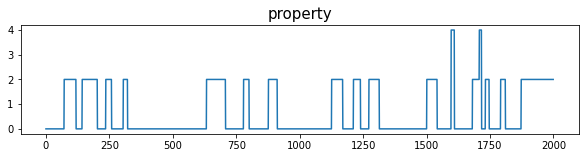

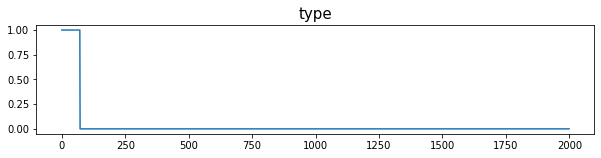

In [9]:
for i in range(4):
    plt.figure(figsize=(10,2))
    plt.title(legends2[i], fontsize=15)
    plt.plot(data_map[:2000,0,i])
    plt.show()

In [10]:
print(data_past.shape)
print(type(data_past))

(351265, 20, 6)
<class 'numpy.ndarray'>


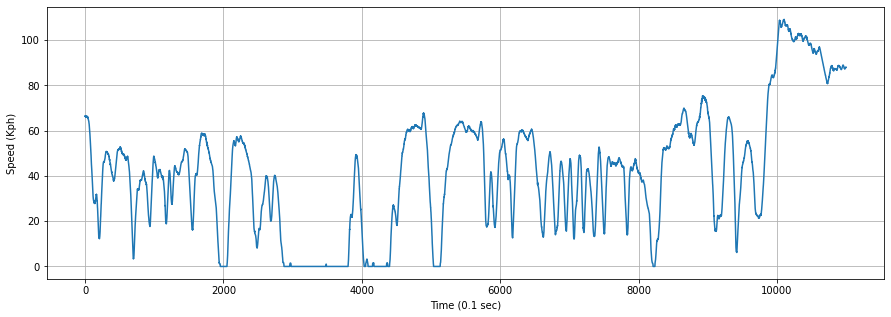

In [11]:
plt.figure(figsize=(15,5))
plt.plot(data_past[:11000,0,-1:])
plt.ylabel('Speed (Kph)')
plt.xlabel('Time (0.1 sec)')
plt.grid()

### 1. Model analysis w.r.t a sample

In [12]:
print(np.max(scaled_data_past))
print(np.min(scaled_data_past))

1.0
-0.7361876


In [26]:
# Parameters
# Sample index
# idx = 246289
idx = np.random.choice(300000, 1)[0]

output_time_steps=10
pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

# Data Sampling
x_past = scaled_data_past[idx:idx+1]
x_forward = scaled_data_map[idx:idx+1]
y = scaled_data_pred[idx:idx+1]
print(f'Past data shape: {x_past.shape}')
print(f'Forward data shape: {x_forward.shape}')
print(f'Prediction target data shape: {y.shape}')

Past data shape: (1, 20, 6)
Forward data shape: (1, 100, 4)
Prediction target data shape: (1, 10, 1)


past data
- pv
- aglSteering
- prBrake
- distObject
- spdObject
- speed

#### 1.1 Inference

In [27]:
output = model(x_past, x_forward, pos_enc_past, pos_enc_fwd)

mse
[[ 0.0124]
 [ 0.1597]
 [ 0.9924]
 [ 0.0292]
 [ 0.0808]
 [ 0.4683]
 [ 6.2191]
 [22.0673]
 [42.1031]
 [86.0115]]
mean =  15.814374
mae
[[0.1112]
 [0.3996]
 [0.9962]
 [0.1708]
 [0.2842]
 [0.6843]
 [2.4938]
 [4.6976]
 [6.4887]
 [9.2742]]
mean =  2.5600727


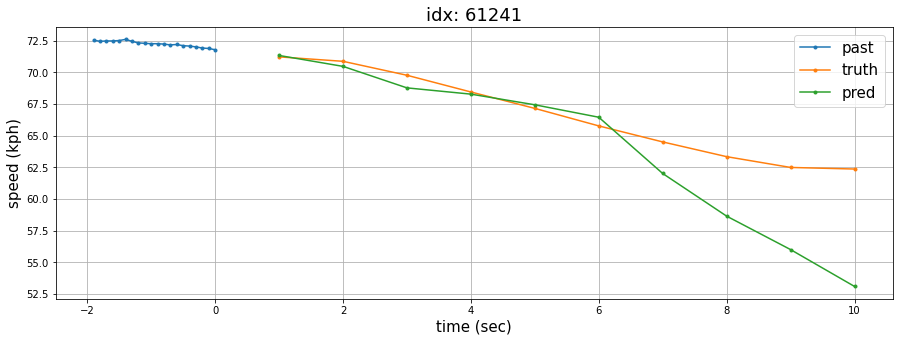

In [28]:
# Error evaluation
error = pred_max * (y-output)
mse = np.mean(np.square(error), axis=0)
mae = np.mean(np.abs(error), axis=0)

np.set_printoptions(precision=4, suppress=True)
print("mse")
print(mse)
print("mean = ", np.mean(mse))
print("mae")
print(mae)
print("mean = ", np.mean(mae))

# Results Visualize
x1 = np.arange(1, 21)*0.1 - 2
x2 = np.arange(1, 11)
plt.figure(figsize=(15,5))
plt.title('idx: %s'%format(idx), fontsize=18)
plt.plot(x1, (x_past*past_max)[0, :, -1], '.-', label='past')
plt.plot(x2, y[0]*pred_max[0], '.-', label='truth')
plt.plot(x2, output[0]*pred_max, '.-', label='pred')
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('speed (kph)', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

# LRP Implementation

In [29]:
from lrp import get_act_model, RelevancePropagation
import tensorflow.compat.v1 as tf1
from tensorflow.python.ops import nn_ops

In [30]:
model.output_time_steps = 10
tf1.reset_default_graph()
get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[0.4941],
        [0.4881],
        [0.4764],
        [0.473 ],
        [0.4671],
        [0.4603],
        [0.4295],
        [0.4062],
        [0.3879],
        [0.3677]]], dtype=float32)>

In [31]:
tf1.get_default_graph().get_all_collection_keys()

['past_conv',
 'code_past_enc',
 'query',
 'att_key',
 'att_v1',
 'att_v2',
 'att_e',
 'alpha',
 'att_feature',
 'forward_conv',
 'concat_code',
 'dense4',
 'diff']

In [32]:
lrp = RelevancePropagation()
rel_input, rel_forward = lrp.run_lrp_input(model, x_past, x_forward, pos_enc_past, pos_enc_fwd, prnt=True)
# print('check the sum of relev_input: ', tf.reduce_sum(rel_input))
# print('check the sum of relev_forward: ', tf.reduce_sum(rel_forward))
print('check the shape of relev_input: ', rel_input.shape)
print('check the shape of relev_forward: ', rel_forward.shape)
msize = rel_input[0]

[Value]
Past Relevance: 0.135373, Forward Relevance: 0.169923
[Percentage]
Past Relevance: 44.34, Forward Relevance: 55.66
check the shape of relev_input:  (1, 20, 6)
check the shape of relev_forward:  (1, 100, 8)


## LRP visualization

In [34]:
cmap_list = ['Reds', 'Oranges', 'Greens', 'Blues','Purples', 'Greys']
c_list = ['r' ,'coral', 'limegreen', 'dodgerblue', 'mediumpurple', 'gray']

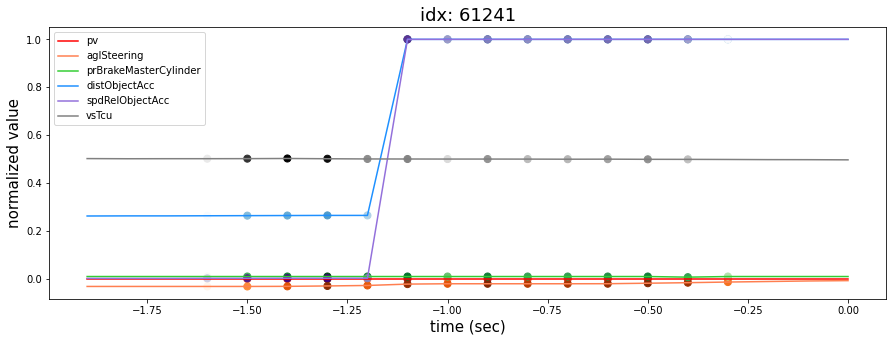

In [35]:
plt.figure(figsize=(15,5))

# plt.plot(x1, x_past[0], '.-')
legends = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']

for i in range(6):
    plt.plot(x1, x_past[0,:,i], '-', c=c_list[i], label=legends[i])
    plt.scatter(x1[3:-3], x_past[0,3:-3,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[3:-3,i])
    
plt.title('idx: %s'%format(idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(loc='best')

In [36]:
input_vars = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']

<BarContainer object of 6 artists>

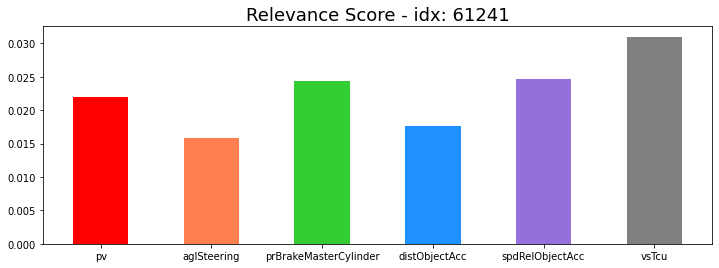

In [37]:
plt.figure(figsize=(12,4))
plt.title('Relevance Score - idx: %s'%format(idx), fontsize=18)
plt.bar(input_vars, tf.reduce_sum(rel_input[0], axis=0), color=c_list, width=0.5)

### Prototype Grouping

In [39]:
'''이전에 알고리즘을 돌린 결과를 저장한 인덱스 값'''
proto_indices = np.array([206719, 245247, 242974, 19816, 183602, 258237, 155661, 16503, 151977, 182308, 147410, 339701, 80710, 100287, 308485, 180777, 306122, 123046, 219143, 328217, 319560, 86747,
                          257775, 348141, 48825, 86695, 281289, 125678, 342719, 172892])


In [40]:
bs = 300 # batch size
code_list = []

for i in range(351265//bs):
    x_past = scaled_data_past[i*bs:(i+1)*bs]
    code_past = model.relu(model.dense1(model.flatten(model.enc_past(x_past))))
    code_list.append(code_past)
    
code_past_all = np.vstack(code_list)
print(code_past_all.shape)

(351000, 32)


In [41]:
normalized_code = code_past_all / np.linalg.norm(code_past_all, axis=1)[:, np.newaxis]

In [42]:
from sklearn.metrics.pairwise import linear_kernel

feature_kernel = np.power(linear_kernel(normalized_code, normalized_code[proto_indices]), 30)

In [43]:
n_cluster = 25
proto_class = np.argmax(feature_kernel[:,:n_cluster], axis=1)

(array([20441., 26322., 21949., 13519., 24111., 22558., 17718., 14855.,
        17509., 16295., 17387.,  8610.,  8689., 12488.,  9862.,  9776.,
        10176., 12163., 15444.,  9737., 10374., 10291.,  5271.,  4750.,
        10705.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <BarContainer object of 25 artists>)

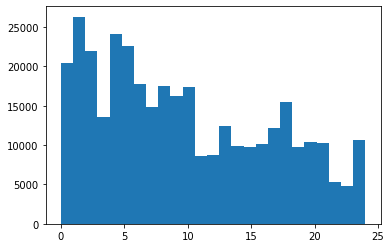

In [45]:
plt.hist(proto_class, bins=25)

# XAI test

In [86]:
cmap_list = ['Reds', 'Oranges', 'Greens', 'Blues','Purples', 'Greys']
c_list = ['r' ,'coral', 'limegreen', 'dodgerblue', 'mediumpurple', 'gray']
input_vars = ['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
legends = input_vars

### load relevance data

In [87]:
with open('./relevance_past_dict.pickle', 'rb') as f:
    rel_past_dict = pickle.load(f)
    
with open('./relevance_forward_dict.pickle', 'rb') as f:
    rel_forward_dict = pickle.load(f)
    
with open('./relevance_past_avg.pickle', 'rb') as f:
    rel_past_avg_list = pickle.load(f)
    
with open('./relevance_past_std.pickle', 'rb') as f:
    rel_past_std_list = pickle.load(f)


In [88]:
total_rel_mean = np.mean(np.vstack(rel_past_avg_list), axis=0)
total_rel_std = np.mean(np.vstack(rel_past_std_list), axis=0)

## sample a data point & provide explanation

In [89]:
'''random sampling 원하는 경우'''
idx = np.random.choice(300000, 1)[0]

'''특정 prototype에서 뽑고 싶은 경우''' 
# proto_group = 1 #원하는 그룹 번호
# tmp_indices = np.where(proto_class==proto_group)[0]
# idx = np.random.choice(tmp_indices, 1)[0]

output_time_steps=10
pos_enc_past = tf.tile(tf.expand_dims(pos_encoder(np.arange(10), 40), axis=0), [1, 1, 1])
pos_enc_fwd = tf.tile(tf.expand_dims(pos_encoder(np.arange(100)), axis=0), [1, 1, 1])

# Data Sampling
x_past = scaled_data_past[idx:idx+1]
x_forward = scaled_data_map[idx:idx+1]
y = scaled_data_pred[idx:idx+1]
print(f'Past data shape: {x_past.shape}')
print(f'Forward data shape: {x_forward.shape}')
print(f'Prediction target data shape: {y.shape}')

Past data shape: (1, 20, 6)
Forward data shape: (1, 100, 4)
Prediction target data shape: (1, 10, 1)


In [90]:
output = model(x_past, x_forward, pos_enc_past, pos_enc_fwd)

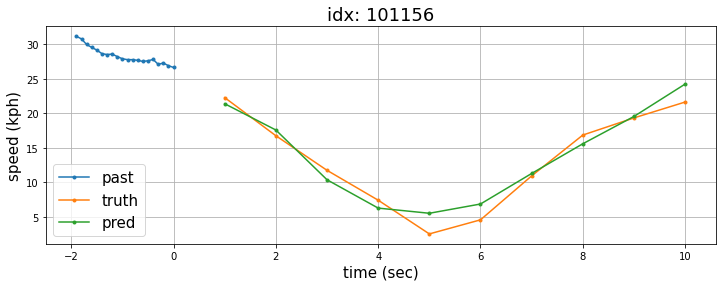

In [91]:
# Error evaluation
error = pred_max * (y-output)
mse = np.mean(np.square(error), axis=0)
mae = np.mean(np.abs(error), axis=0)

np.set_printoptions(precision=4, suppress=True)

# Results Visualize
x1 = np.arange(1, 21)*0.1 - 2
x2 = np.arange(1, 11)
plt.figure(figsize=(12,4))
plt.title('idx: %s'%format(idx), fontsize=18)
plt.plot(x1, (x_past*past_max)[0, :, -1], '.-', label='past')
plt.plot(x2, y[0]*pred_max[0], '.-', label='truth')
plt.plot(x2, output[0]*pred_max, '.-', label='pred')
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('speed (kph)', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

In [92]:
model.output_time_steps = 10
tf1.reset_default_graph()
get_act_model(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)

<tf.Tensor: shape=(1, 10, 1), dtype=float32, numpy=
array([[[0.1482],
        [0.1219],
        [0.072 ],
        [0.0435],
        [0.0384],
        [0.0476],
        [0.0783],
        [0.1081],
        [0.1355],
        [0.168 ]]], dtype=float32)>

In [93]:
lrp = RelevancePropagation()
rel_input, rel_forward = lrp.run_lrp_input(model, x_past, x_forward, pos_enc_past, pos_enc_fwd)

In [94]:
proto_group = proto_class[idx]

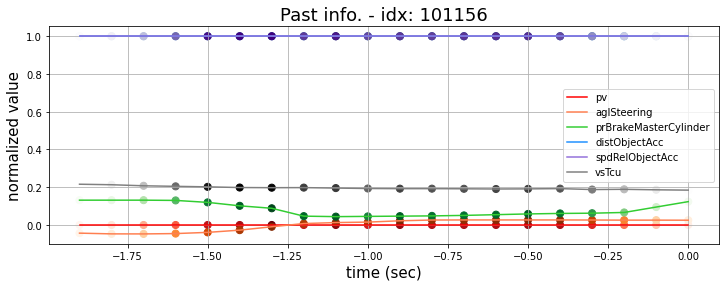

In [98]:
plt.figure(figsize=(12,4))

for i in range(6):
    plt.plot(x1, x_past[0,:,i], '-',c=c_list[i], label=legends[i])
    plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])
    
plt.title('Past info. - idx: %s'%format(idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.grid()
plt.legend(loc='best')

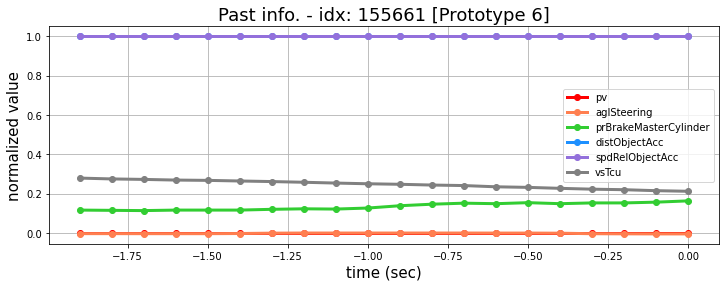

In [100]:
'''Prototype의 과거 내부 변수'''
plt.figure(figsize=(12,4))
x_proto = scaled_data_past[proto_indices[proto_group]]
for i in range(6):
    plt.plot(x1, x_proto[:,i], '-o',c=c_list[i], linewidth=3)
plt.title('Past info. - idx: %s [Prototype %s]'%(proto_indices[proto_group], proto_group), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()


<BarContainer object of 6 artists>

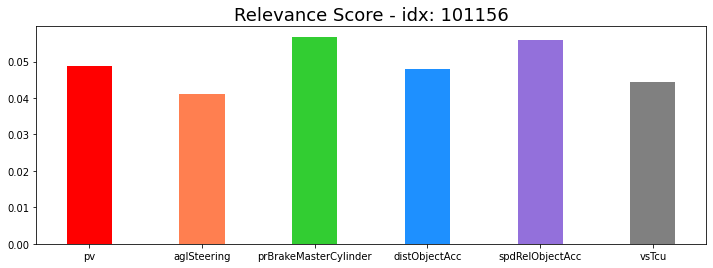

In [104]:
plt.figure(figsize=(12,4))
plt.title('Relevance Score - idx: %s'%format(idx), fontsize=18)
plt.bar(input_vars, tf.reduce_sum(rel_input[0], axis=0), color=c_list, width=0.4)
# plt.ylim((0,0.2))

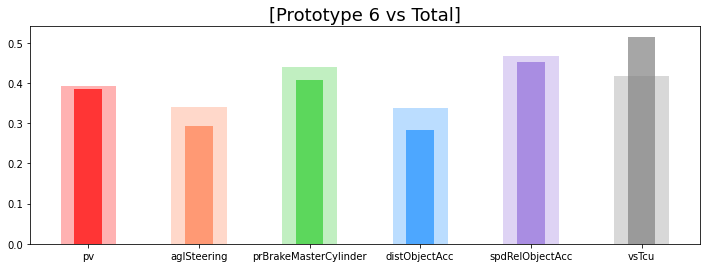

In [105]:
pg = proto_group
plt.figure(figsize=(12,4))
plt.title('[Prototype %d vs Total]'%(pg), fontsize=18)
plt.bar(input_vars, total_rel_mean, color=c_list, width=0.5, alpha=0.3)
plt.bar(input_vars, tmp_mean, color=c_list, width=0.25, alpha=0.7)
plt.show()

## Attention

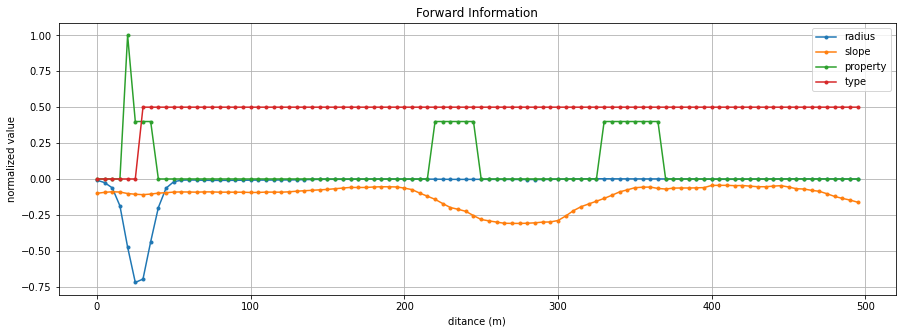

In [106]:
xf = np.arange(100)*5

plt.figure(figsize=(15,5))
plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('ditance (m)')
plt.ylabel('normalized value')
plt.title('Forward Information')
plt.grid()

In [107]:
code_past = model.relu(model.dense1(model.flatten(model.enc_past(x_past))))
code_past = tf.tile(tf.expand_dims(code_past, axis=1), [1, output_time_steps, 1])

(1, 10, 36)
(1, 10, 32)
(1, 100, 16)


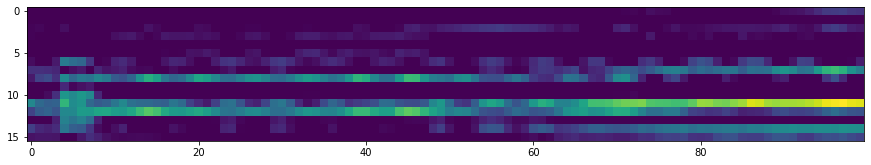

In [111]:
query = tf.concat([code_past, pos_enc_past], axis=-1)
print(query.shape)

query = model.relu(model.dense2(query))
print(query.shape)

feature = tf.concat([x_forward, pos_enc_fwd], axis=-1)
feature = model.spatial_att.relu(model.spatial_att.dense2(model.spatial_att.relu(model.spatial_att.dense1(feature))))

print(feature.shape)

plt.figure(figsize=(15,5))
plt.imshow(tf.transpose(feature, [0, 2, 1])[0])

In [112]:
v1 = model.spatial_att.u_e(feature)
v2 = model.spatial_att.w_e(query)

v2 = tf.expand_dims(v2, axis=2)  # shape: [batch, self.output_time_steps, 1, units]
e_t = tf.squeeze(model.spatial_att.v_e(model.spatial_att.tanh(v1 + v2)), axis=-1)  # shape: [batch, self.output_time_steps, feature_length]
alpha_t = model.spatial_att.softmax(e_t)  # shape: [batch, self.output_time_steps, feature_length]

In [113]:
alpha = model.spatial_att(query, tf.expand_dims(tf.concat([x_forward, pos_enc_fwd],axis=-1), axis=1))

Text(0.5, 1.0, 'alpha')

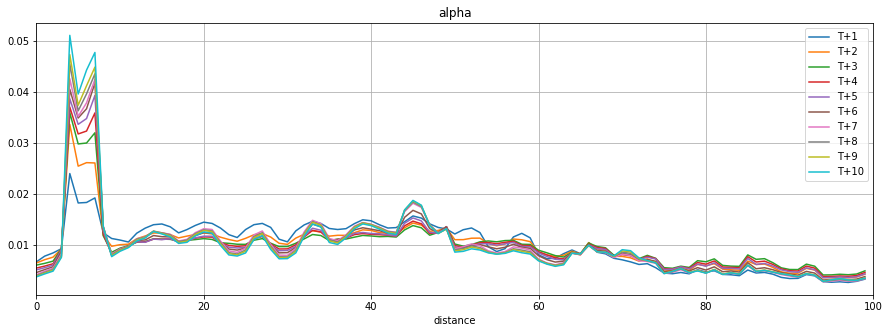

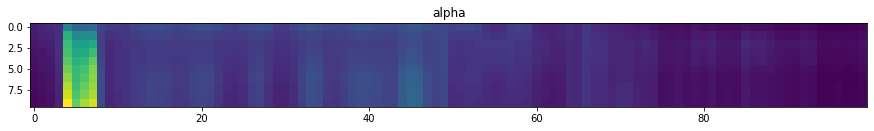

In [114]:
# visualize
plt.figure(figsize=(15,5))
for i in range(alpha.shape[1]):
    plt.plot(alpha[0, i], label='T+'+str(i+1))
plt.xlim([0, 100])
plt.xlabel('distance')
plt.title('alpha')
plt.legend()
plt.grid()

plt.figure(figsize=(15,5))
plt.imshow(alpha[0])
plt.title('alpha')

Text(0.5, 1.0, 'alpha')

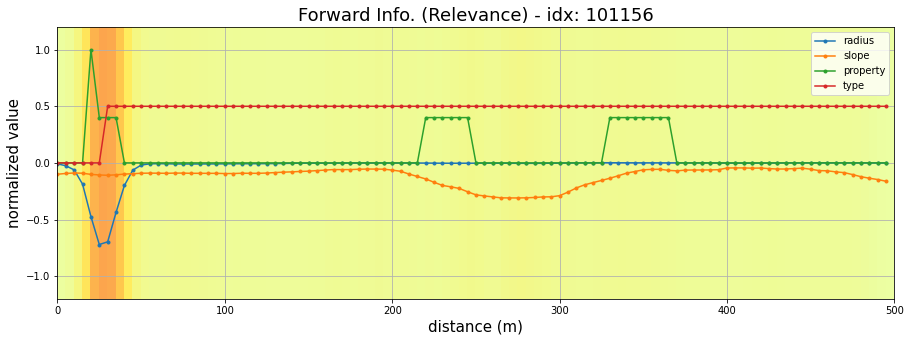

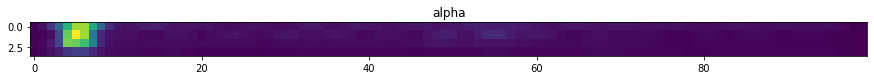

In [115]:
rel_mean = np.mean(rel_forward[0,:,:], axis=1)

plt.figure(figsize=(15,5))

plt.imshow(rel_mean[np.newaxis,:], cmap="Wistia", aspect='auto', alpha=0.7, extent=[0,500,-1.2,1.2])

plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('distance (m)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.title('Forward Info. (Relevance) - idx: %s'%format(idx), fontsize=18)
plt.grid()

plt.figure(figsize=(15,5))
plt.imshow(np.transpose(rel_forward[0,:,:4]))
plt.title('alpha')

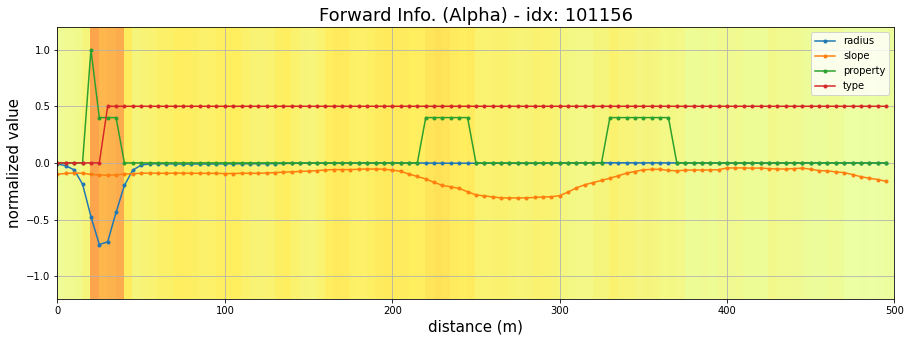

In [117]:
alpha_mean = np.mean(alpha[0], axis=0)

plt.figure(figsize=(15,5))

plt.imshow(alpha_mean[np.newaxis,:], cmap="Wistia", aspect='auto', alpha=0.7, extent=[0,500,-1.2,1.2])

plt.plot(xf, x_forward[0], '.-')
plt.legend(['radius', 'slope', 'property', 'type'])
plt.xlabel('distance (m)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.title('Forward Info. (Alpha) - idx: %s'%format(idx), fontsize=18)
plt.grid()



---

---

---

# Prototype Selection Algorithm

## Latent code_past extraction

In [558]:
scaled_data_past.shape

(351265, 20, 6)

In [559]:
bs = 300 # batch size
code_list = []

for i in range(351265//bs):
    x_past = scaled_data_past[i*bs:(i+1)*bs]
    code_past = model.relu(model.dense1(model.flatten(model.enc_past(x_past))))
    code_list.append(code_past)
    
code_past_all = np.vstack(code_list)
print(code_past_all.shape)


KeyboardInterrupt: 

## Prototype Selection

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel

import sys

def greedy_protos(K, candidate_indices, m):

    if len(candidate_indices) != np.shape(K)[0]:
        K = K[:,candidate_indices][candidate_indices,:]

    n = len(candidate_indices)

    colsum = 2*np.sum(K, axis=0) / n
    selected = np.array([], dtype=int)

    f_list = []
    cond_list = []
    nsk = 0
    
    for i in range(m):
        maxx = -sys.float_info.max
        argmax = -1
        candidates = np.setdiff1d(range(n), selected)

        s1array = colsum[candidates]
        lenS = len(selected)
        if lenS > 0:
            temp = K[selected, :][:, candidates]
            s2array = np.sum(temp, axis=0) *2 + np.diagonal(K)[candidates]
            s2array = s2array/(lenS + 1)
            s3array = s1array - s2array
        else:
            s3array = s1array - (np.abs(np.diagonal(K)[candidates]))
        
        max_idx = np.argmax(s3array)
        if lenS > 0:
            sk = np.sum(K[selected, :][:, selected])
            f = s3array[max_idx]/(lenS+1) - nsk/(lenS*(lenS+1)) + (1/(lenS**2)-1/((lenS+1)**2))*sk
            f_list.append(f)
        else:
            f_list.append(s3array[max_idx])
        
        argmax = candidates[max_idx]
        selected = np.append(selected, argmax)
        
        '''nsk: (2/n)*\sum{k([n],S)}'''
        nsk += s1array[max_idx]

    return candidate_indices[selected], f_list

In [ ]:
indices = np.random.choice(351000, 30000, replace=False)

In [ ]:
normalized_code = code_past_all[indices] / np.linalg.norm(code_past_all[indices], axis=1)[:, np.newaxis]

In [ ]:
from sklearn.metrics.pairwise import linear_kernel

feature_kernel = np.power(linear_kernel(normalized_code), 30)

In [ ]:
n_samples = len(normalized_code)
n_cluster = 30
kernel_matrix = feature_kernel

In [292]:
%%time
selected, f_list = greedy_protos(kernel_matrix, np.arange(n_samples), n_cluster)
print(selected)

[ 4407 19752  5746  1426 14842 21951  8122 26764 12818 26280 11688  2432
 26347  2241 19284 23717 29220  7369 25396 15278 14736  6311  8295    58
 29988 28142  1252 18568 22406  8601]
CPU times: user 531 ms, sys: 15.5 ms, total: 547 ms
Wall time: 545 ms


In [657]:
indices[selected]

array([206719, 245247, 242974,  19816, 183602, 258237, 155661,  16503,
       151977, 182308, 147410, 339701,  80710, 100287, 308485, 180777,
       306122, 123046, 219143, 328217, 319560,  86747, 257775, 348141,
        48825,  86695, 281289, 125678, 342719, 172892])

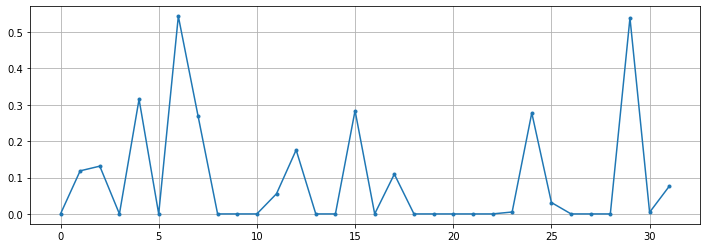

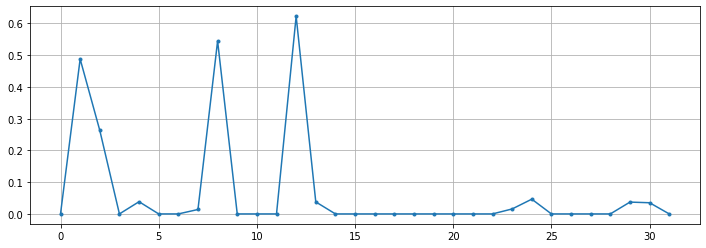

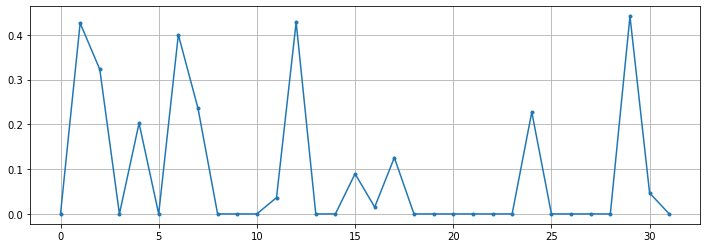

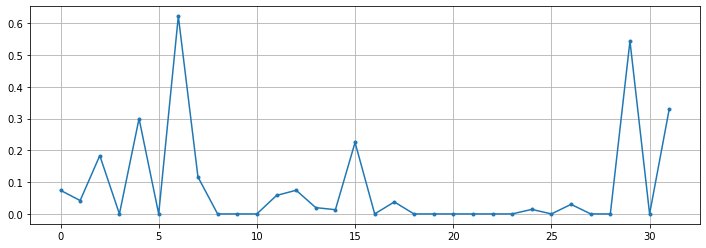

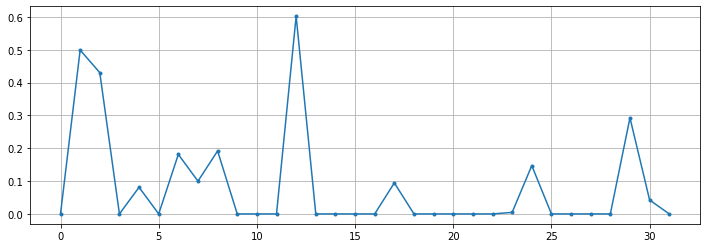

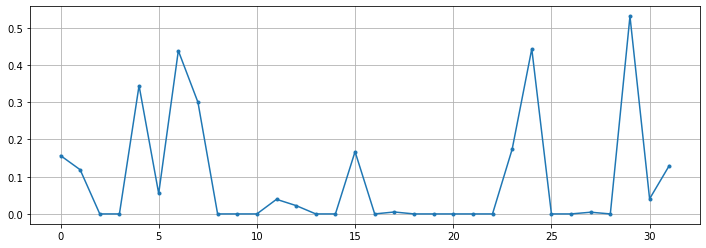

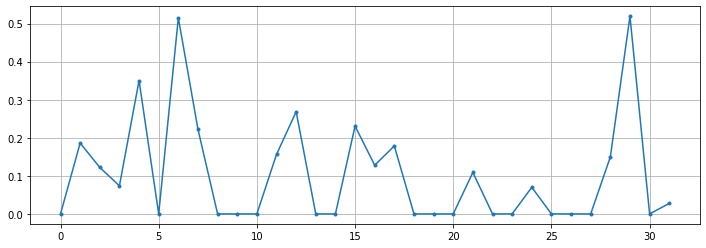

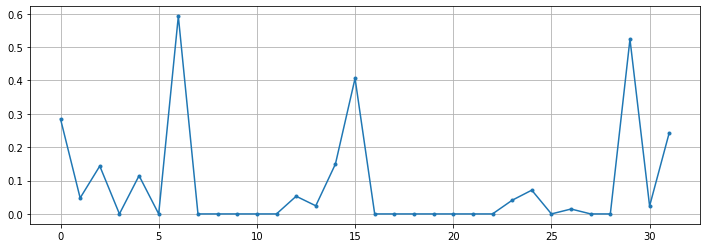

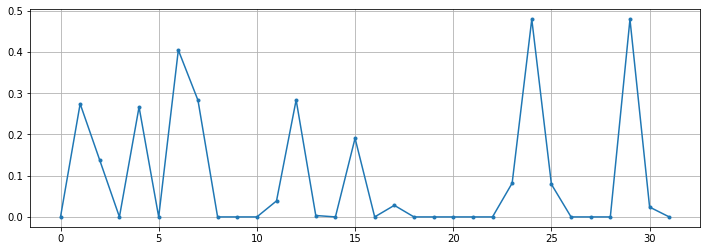

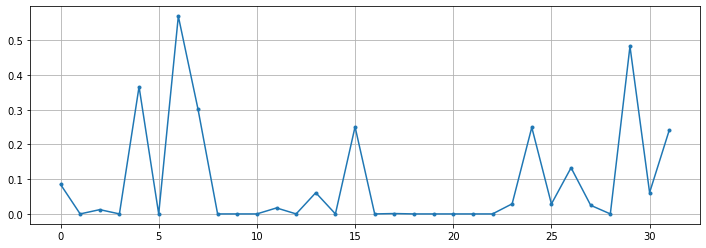

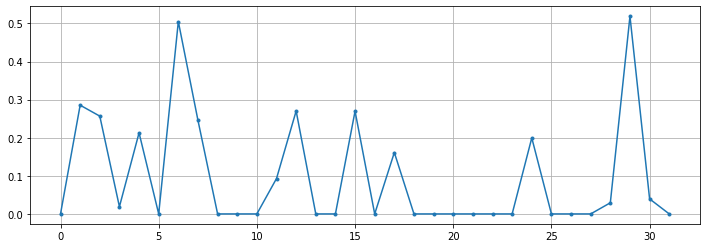

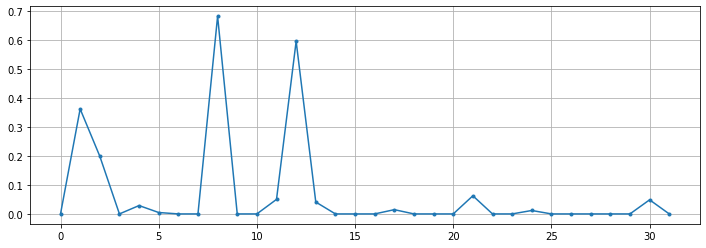

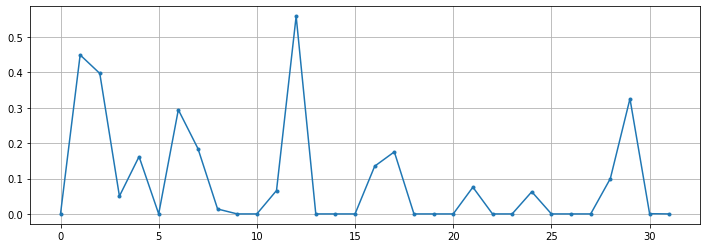

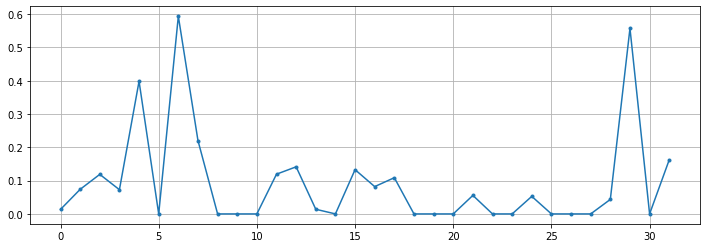

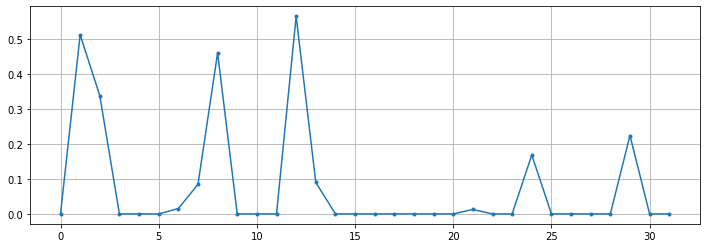

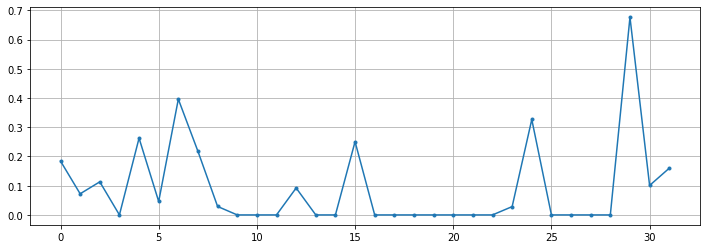

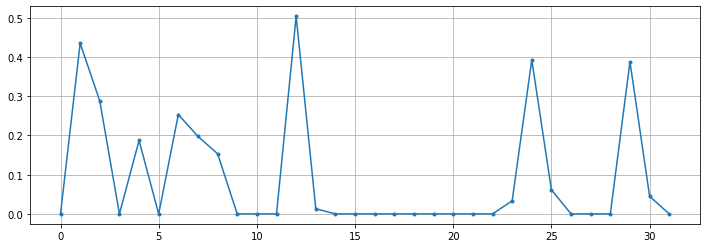

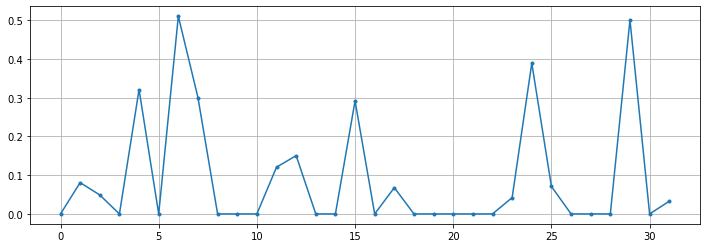

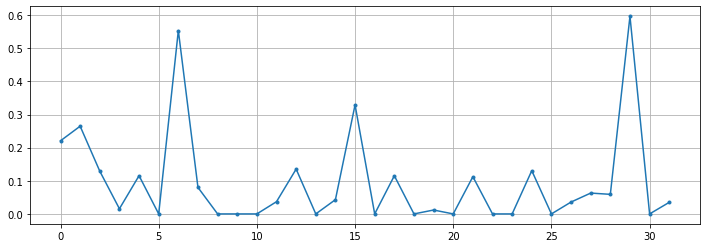

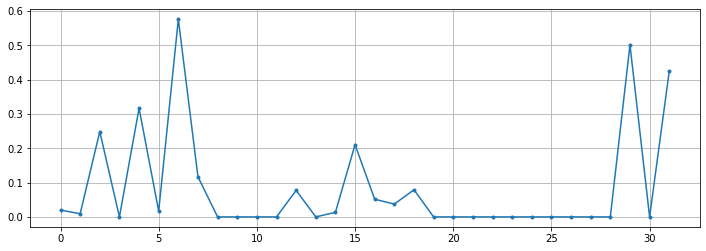

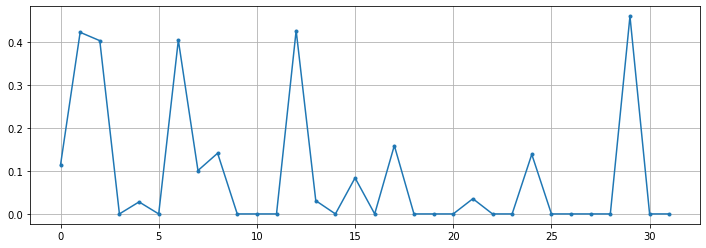

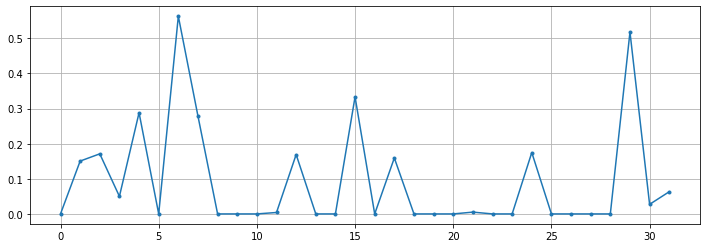

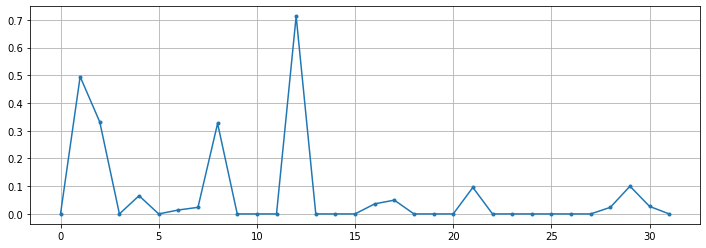

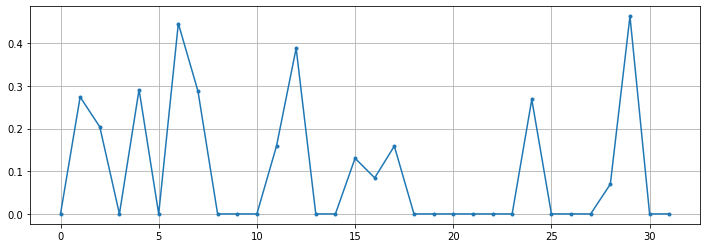

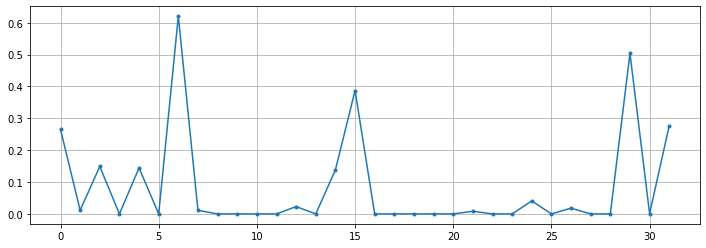

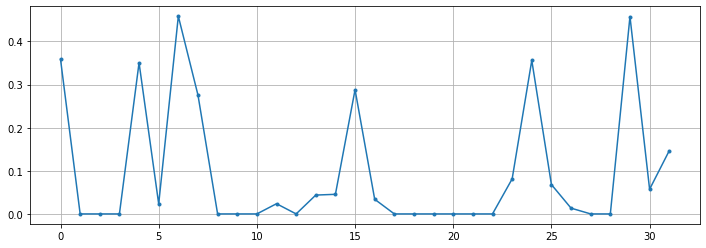

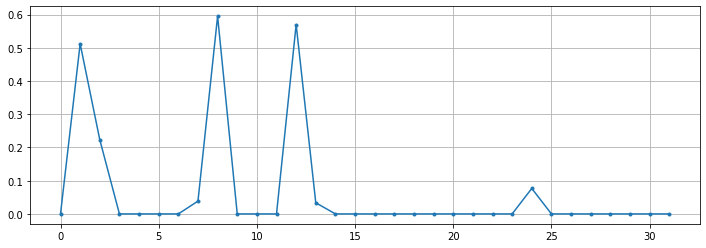

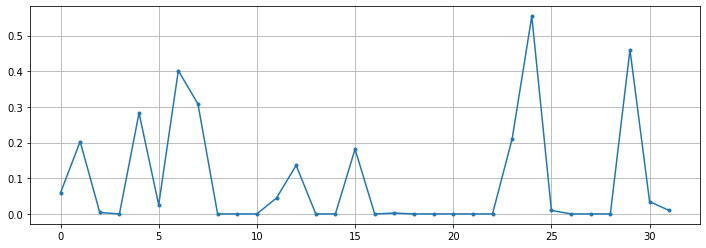

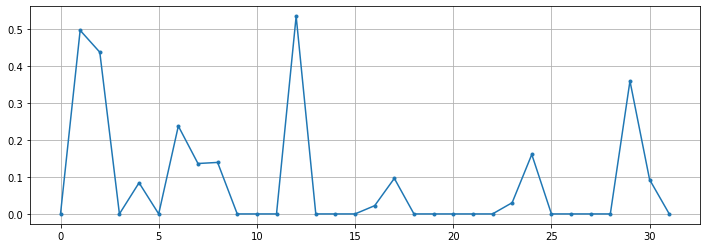

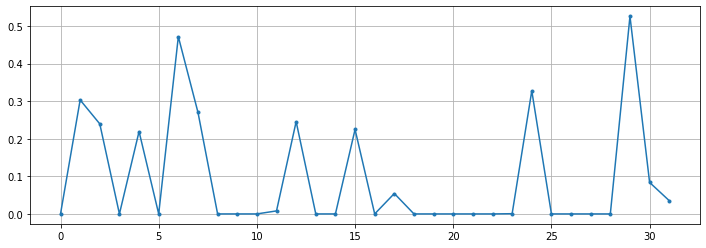

In [293]:
for i in selected:
    plt.figure(figsize=(12,4))
    plt.plot(normalized_code[i], '.-')
    plt.grid()
    plt.show()

In [279]:
np.cumsum(f_list)

array([-0.7506, -0.2971, -0.147 , -0.08  , -0.0419, -0.016 ,  0.0005,
        0.0123,  0.0207,  0.0275,  0.0335,  0.0348,  0.0363,  0.0376,
        0.0387,  0.0402,  0.0413,  0.042 ,  0.043 ,  0.0437])

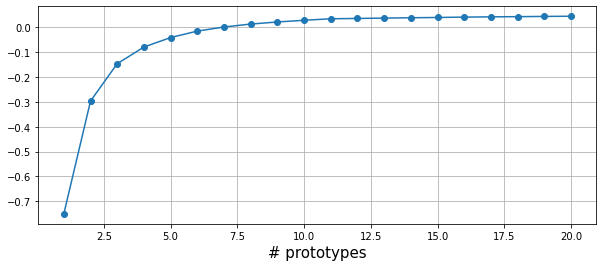

In [280]:
plt.figure(figsize=(10,4))
plt.plot(np.arange(len(f_list))+1,np.cumsum(f_list), '-o')
plt.xlabel('# prototypes', fontsize=15)
plt.grid()

In [308]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(code_past_all[indices])

In [344]:
from sklearn.manifold import TSNE
import time

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
tsne_results = tsne.fit_transform(df)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 30000 samples in 0.001s...
[t-SNE] Computed neighbors for 30000 samples in 20.225s...
[t-SNE] Computed conditional probabilities for sample 1000 / 30000
[t-SNE] Computed conditional probabilities for sample 2000 / 30000
[t-SNE] Computed conditional probabilities for sample 3000 / 30000
[t-SNE] Computed conditional probabilities for sample 4000 / 30000
[t-SNE] Computed conditional probabilities for sample 5000 / 30000
[t-SNE] Computed conditional probabilities for sample 6000 / 30000
[t-SNE] Computed conditional probabilities for sample 7000 / 30000
[t-SNE] Computed conditional probabilities for sample 8000 / 30000
[t-SNE] Computed conditional probabilities for sample 9000 / 30000
[t-SNE] Computed conditional probabilities for sample 10000 / 30000
[t-SNE] Computed conditional probabilities for sample 11000 / 30000
[t-SNE] Computed conditional probabilities for sample 12000 / 30000
[t-SNE] Computed conditional probabilities for sa

In [364]:
n_use = 30
proto_class = np.argmax(kernel_matrix[:,selected[:n_use]], axis=1)

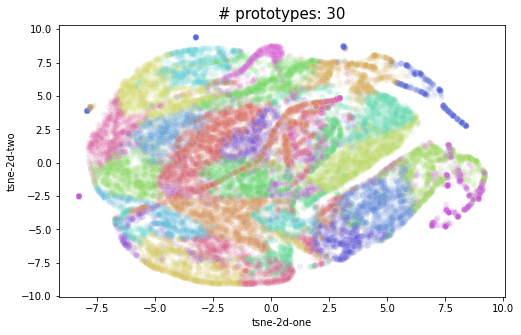

In [365]:
df_subset = pd.DataFrame(columns = ['tsne-2d-one', 'tsne-2d-two']) 
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
df_subset['proto'] = proto_class

plt.figure(figsize=(8,5))
# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two"
# )
plt.title('# prototypes: %d'%(n_use), fontsize=15)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="proto",
    palette=sns.color_palette("hls", n_use),
    data=df_subset,
#     legend="full",
    alpha=0.1
)
plt.legend([],[],frameon=False)
plt.show()

In [366]:
# plt.hist2d(tsne_results[:,0], tsne_results[:,1], 
#            bins=30, cmap=plt.cm.BuPu);

In [368]:
n_use = 25
proto_class = np.argmax(kernel_matrix[:,selected[:n_use]], axis=1)

In [385]:
print(selected[:n_use])

[ 4407 19752  5746  1426 14842 21951  8122 26764 12818 26280 11688  2432
 26347  2241 19284 23717 29220  7369 25396 15278 14736  6311  8295    58
 29988]


In [381]:
''' prototype 중 하나 선택 '''
proto_tar = 15

tmp_indices = np.where(proto_class==proto_tar)[0]

In [382]:

np.random.choice(tmp_indices, 10, replace=False)

array([ 7142,   670,  6381,  5563, 19610, 27126, 29444, 24861,  9693,
       20495])

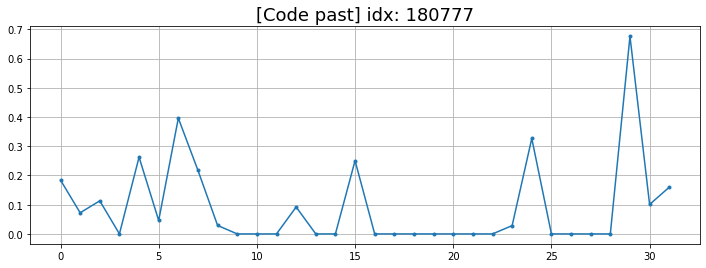

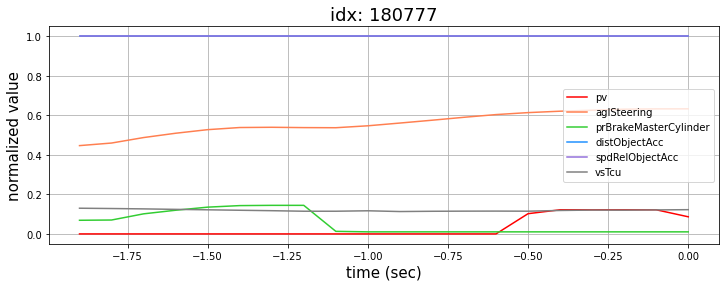

In [383]:
''' prototype code_past 출력 및 input 관찰 '''

sampled_idx = selected[proto_tar]
real_idx = indices[sampled_idx]

plt.figure(figsize=(12,4))
plt.title('[Code past] idx: %s'%format(real_idx), fontsize=18)
plt.plot(normalized_code[sampled_idx], '.-')
plt.grid()
plt.show()

plt.figure(figsize=(12,4))
x_past = scaled_data_past[real_idx]
for i in range(6):
    plt.plot(x1, x_past[:,i], '-',c=c_list[i])
#     plt.scatter(x1, x_past[0,:,i], marker='o', s=50, cmap=cmap_list[i], c=1e4*msize[:,i])

plt.title('idx: %s'%format(real_idx), fontsize=18)
plt.xlabel('time (sec)', fontsize=15)
plt.ylabel('normalized value', fontsize=15)
plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
           , loc='best')
plt.grid()

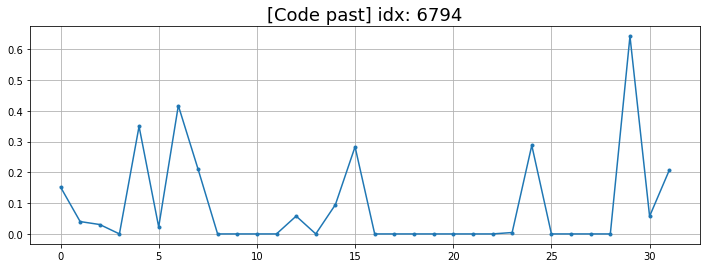

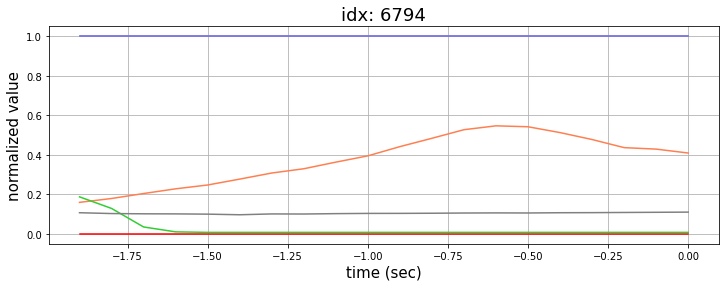

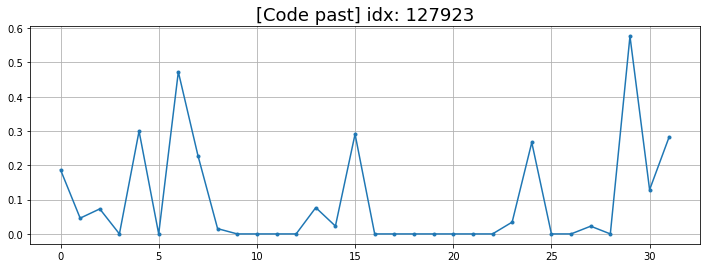

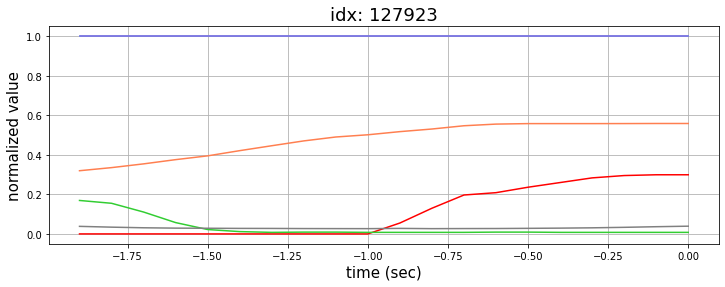

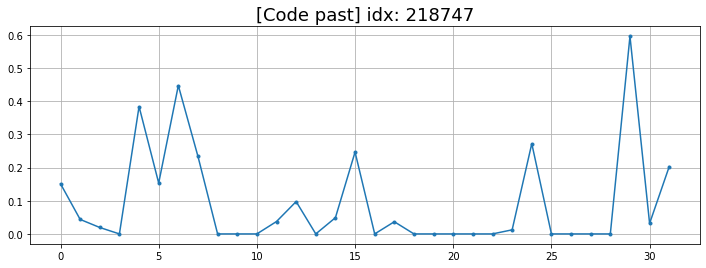

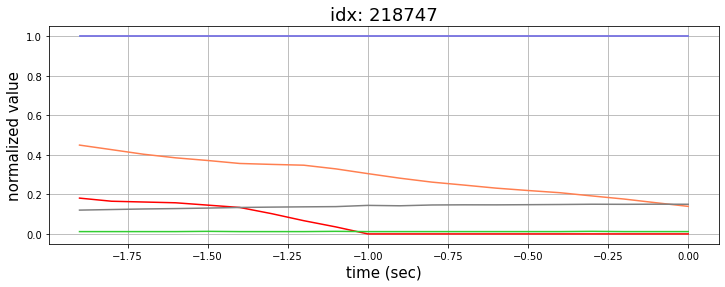

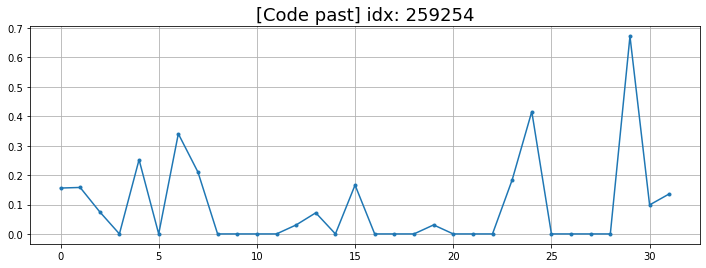

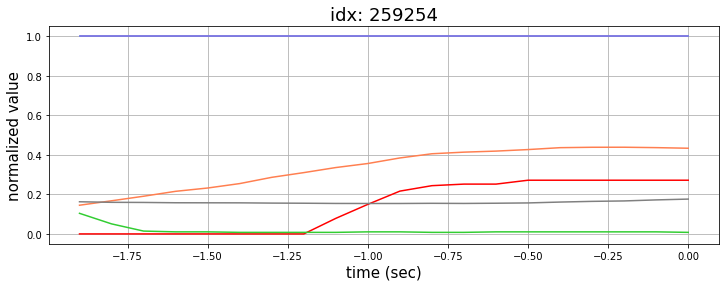

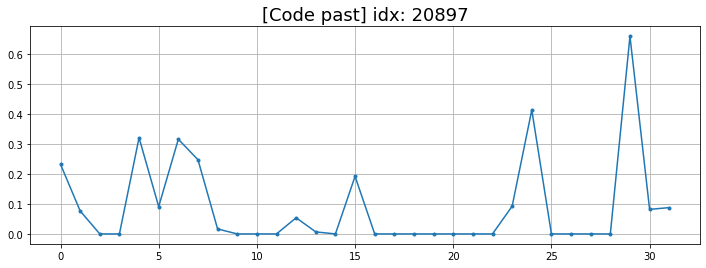

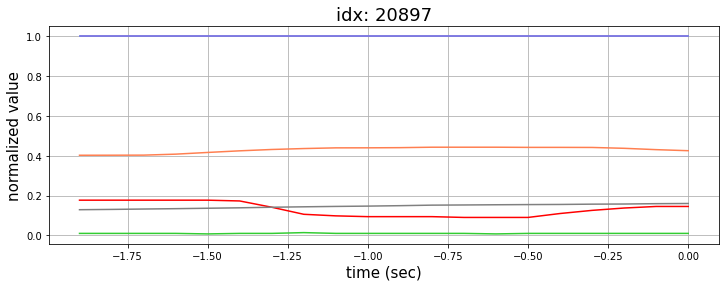

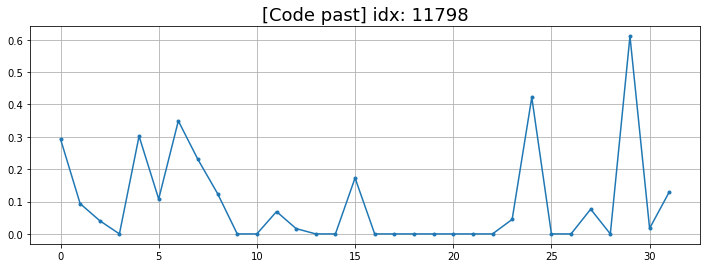

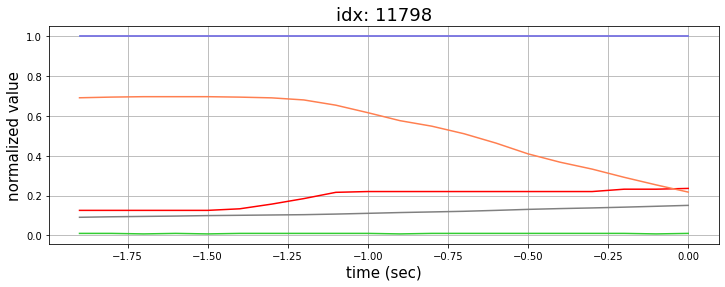

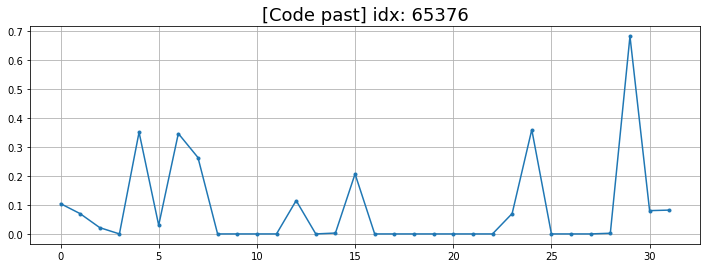

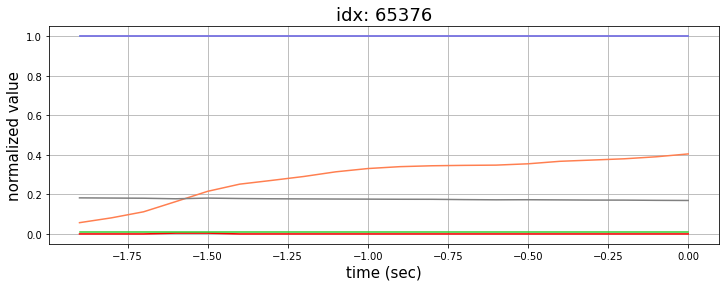

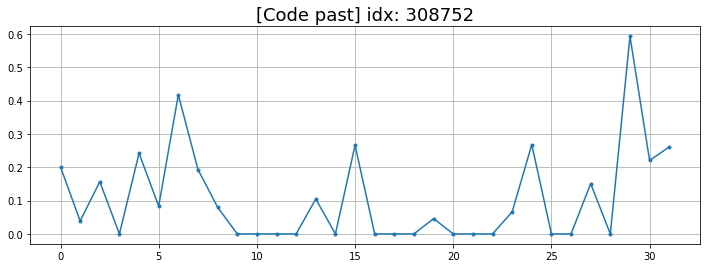

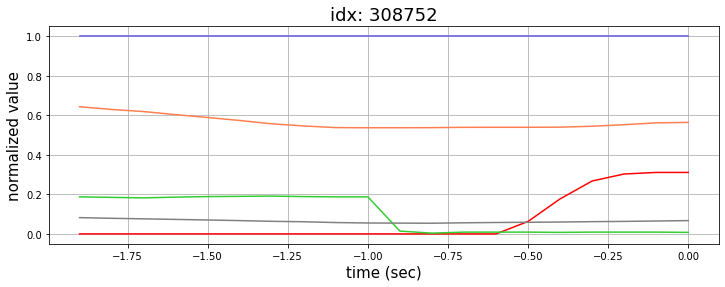

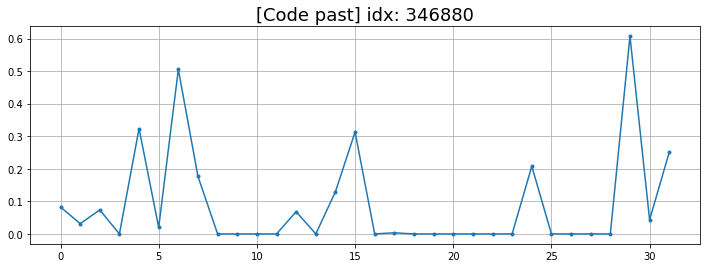

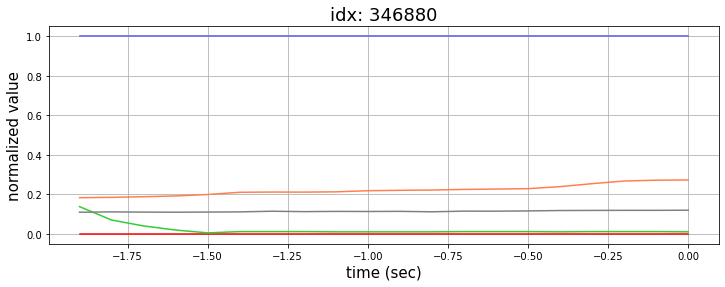

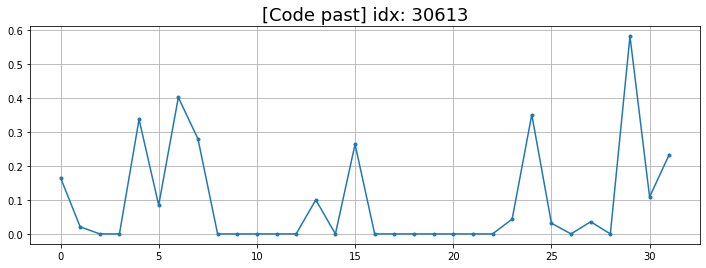

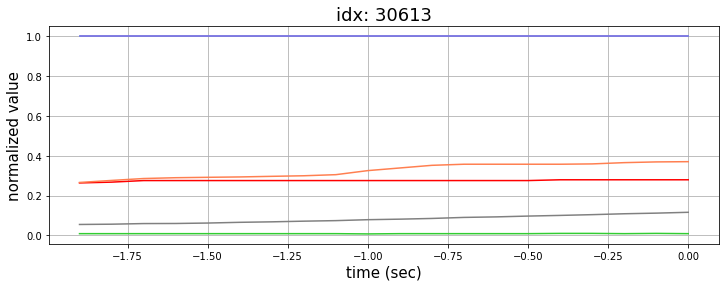

In [384]:
''' 해당 prototype에 속하는 예시 샘플 출력 및 input 관찰 '''

for idx in np.random.choice(tmp_indices, 10, replace=False):
    real_idx = indices[idx]
    
    plt.figure(figsize=(12,4))
    plt.title('[Code past] idx: %s'%format(real_idx), fontsize=18)
    plt.plot(normalized_code[idx], '.-')
    plt.grid()
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.title('idx: %s'%format(real_idx), fontsize=18)
    x_past = scaled_data_past[real_idx]
    for i in range(6):
        plt.plot(x1, x_past[:,i], '-',c=c_list[i])
    plt.xlabel('time (sec)', fontsize=15)
    plt.ylabel('normalized value', fontsize=15)
#     plt.legend(['pv', 'aglSteering', 'prBrakeMasterCylinder', 'distObjectAcc', 'spdRelObjectAcc', 'vsTcu']
#                , loc='best')
    plt.grid()
    

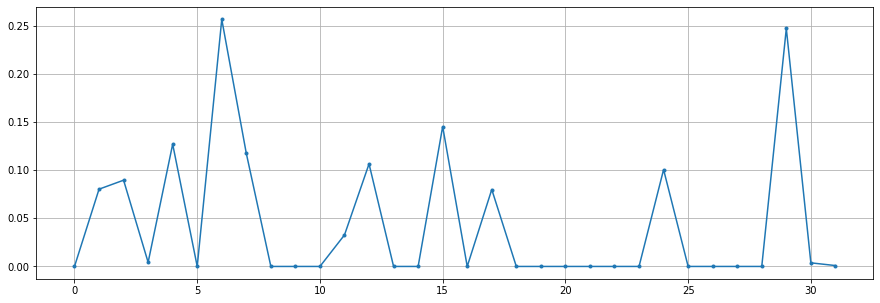

In [1284]:
idx = np.random.choice(300000, 1)[0]

# Visualize code_past
plt.figure(figsize=(15,5))
plt.plot(code_past_all[idx], '.-')
plt.grid()

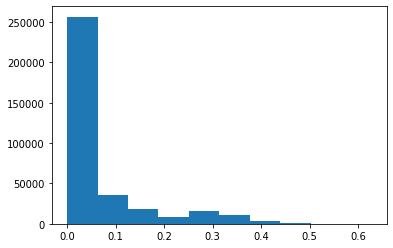

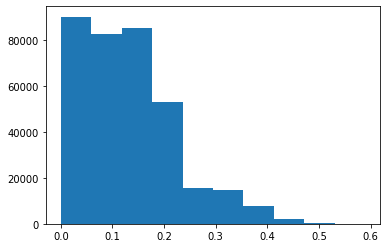

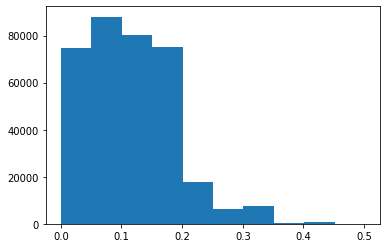

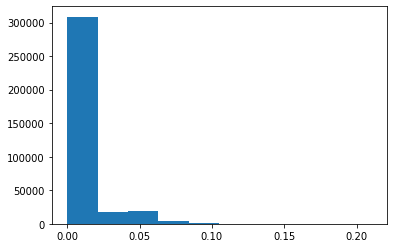

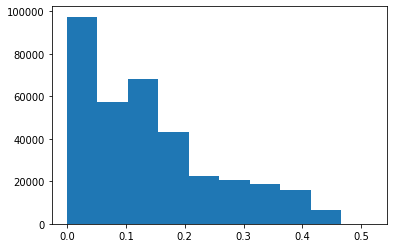

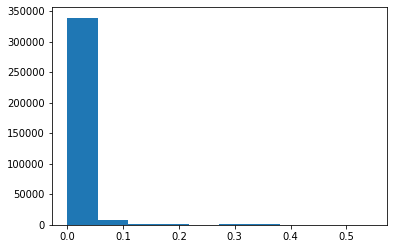

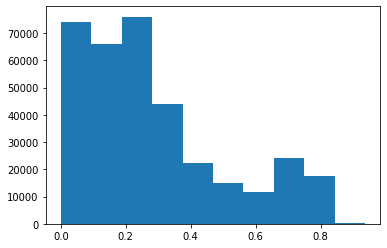

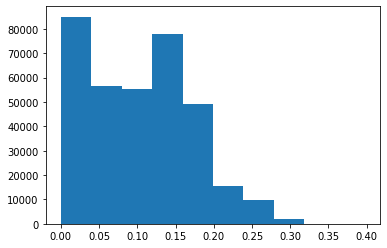

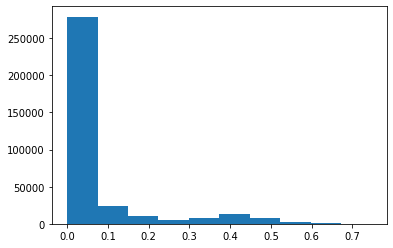

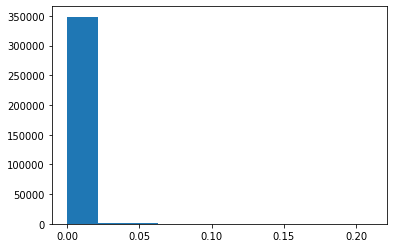

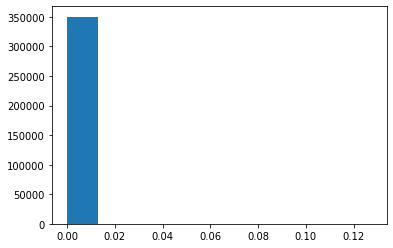

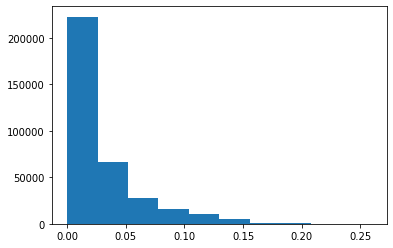

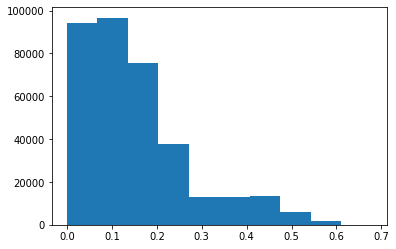

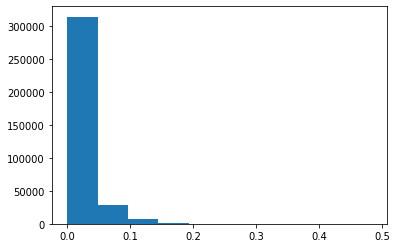

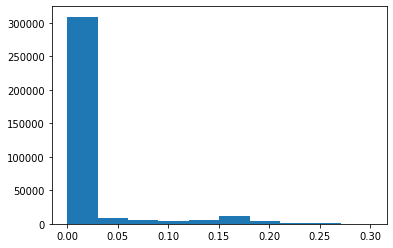

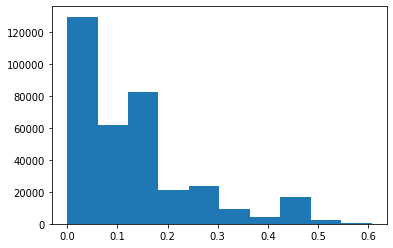

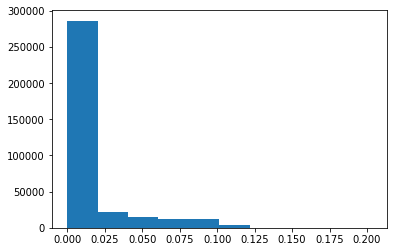

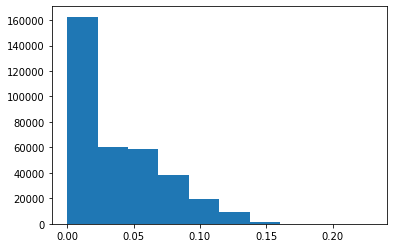

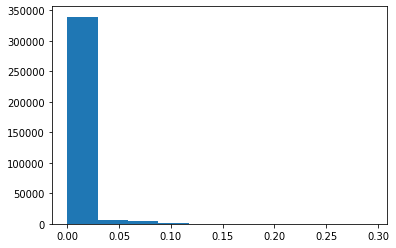

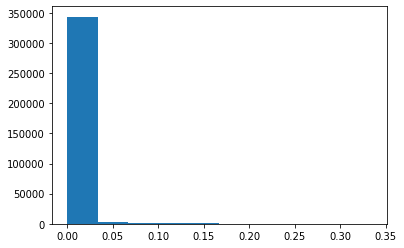

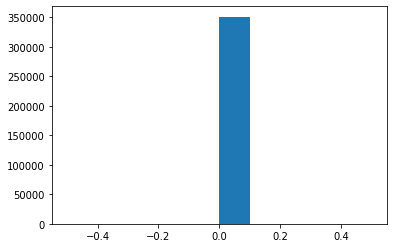

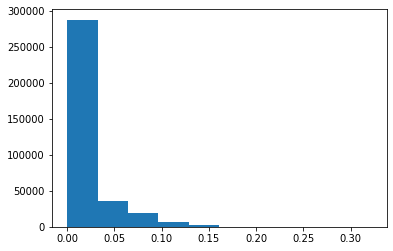

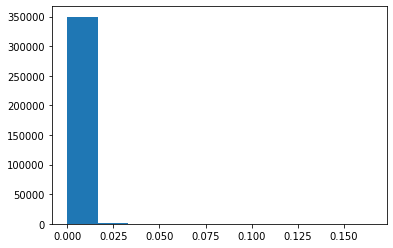

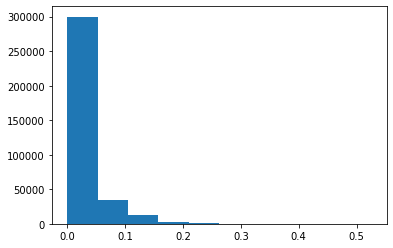

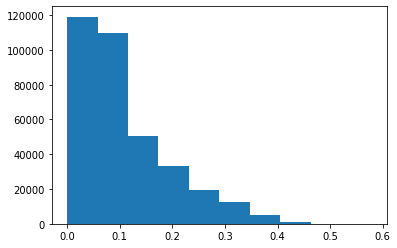

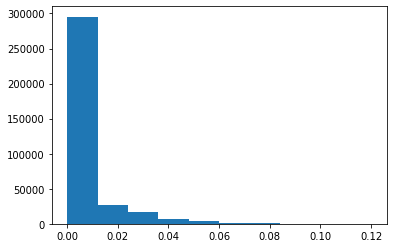

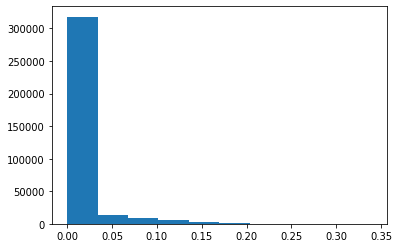

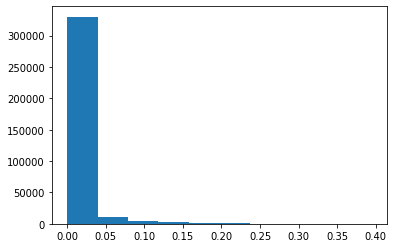

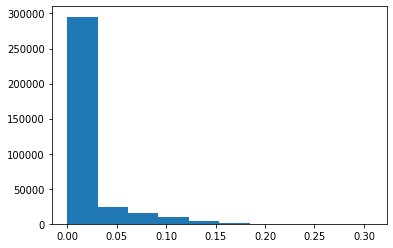

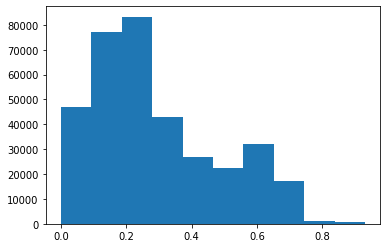

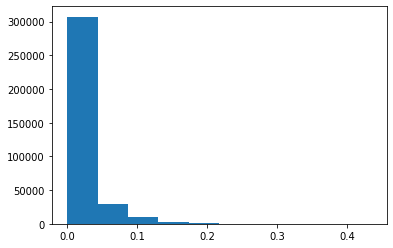

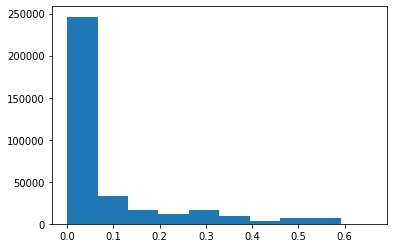

In [1239]:
for i in range(32):
    plt.hist(code_past_all[:,i])
    plt.show()